# Introduction

In this notebook we will optimize disk spacings using the transformer algorithm. When optimizing for a certain frequency range $\nu_{min} - \nu_{max}$
we minimize the cost function $C=-min(\beta ^2 (\nu) | \nu_{min} < \nu < \nu_{max})$. Essentially we take the worst frequency point of the boostfactor curve in this range and try to increase it (by decreasing the negative). This will naturally lead to a flat top hat shape.

To reduce computation we only calculate the boostfactor in the range $\nu_{min} - \nu_{max}$ and keep the number of frequency points to a sensible minimum. With increasing disk number more points are needed to resolve the "wiggles" on top of the boostfactor. 

One also has to choose what boostfactor mode to optimize for. Fundamental mode, other modes, coupled power?

Transformer calculates the mixing between modes which is computationally the most expensive part. In order to make optimization feasable we calculate the mixing for a selected number of points beforehand and then quickly interpolate the exact spacing during optimization. 

For gradient based methods we have to approximate the non-differentiable minimum() with a smooth function like the p-norm.
Still, very close to the minimum the gradient might be unstable and gradient based methods might struggle. 


In [5]:
using BoostFractor
using Optim
using ForwardDiff #If we use gradient-based optimization
using PyPlot
include("transformer_optim_utilities.jl") #Bunch of helper functions

┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1278


p_norm

# Setup

In [6]:
#Physical Parameters
n_disk = 20
epsilon = 24
diskR = 0.15
Mmax = 1
Lmax = 0
#We start with the most generic spacing possible: Equidistant spacing. Make sure the peak is roughly located in the desired 
#frequency range.
init_spacing = 0.007118;


In [7]:
#Frequency range to optimize. For 20 disks 8 points seems sufficient, 80 disks needs ~20-25
freq_center = 22.288e9
freq_width = 50e6
n_freq_optim = 8
freq_min = freq_center-freq_width/2
freq_max = freq_center+freq_width/2
frequencies_optim = range(freq_min,stop=freq_max,length=n_freq_optim);

#For Plotting
df = 0.004*1e9
frequencies_plot = 22.1e9:df:22.6e9;

In [9]:
#Usual transformer setup
# Coordinate System
dx = 0.007
X = -0.5:dx:0.5
Y = -0.5:dx:0.5
coords = SeedCoordinateSystem(X = X, Y = Y)
n_region = 2*n_disk+2

# SetupBoundaries (note that this expects the mirror to be defined explicitly as a region)
eps = Array{Complex{Float64}}([i==1 ? 1e20 : i%2==0 ? 1 : epsilon for i=1:n_region])

distance = Array{Float64}([i==1 ? 0 : i%2==0 ? init_spacing : 1e-3 for i=1:n_region])
distance[end] = 0

#Uncomment to include thickness varation
init_thickness_variation = zeros(n_region,length(X),length(Y))
#xi = 0.035
#sigma = 2e-6;
#init_thickness_variation = surface_roughness(X,Y,n_region,mag=sigma,trunc=sigma*10, xi=xi, diskR=diskR)

sbdry_init = SeedSetupBoundaries(coords, diskno=n_disk, distance=distance, epsilon=eps,relative_surfaces=init_thickness_variation)

# Initialize modes
modes = SeedModes(coords, ThreeDim=true, Mmax=Mmax, Lmax=Lmax, diskR=diskR)

#  Mode-Vector defining beam shape to be reflected on the system
m_reflect = zeros(Mmax*(2*Lmax+1))
m_reflect[Lmax+1] = 1.0;

# Plot Initial Boostfactor 

In [10]:
#Calculate FULL frequency prop matrix of initial setup for plotting
prop_matrix_grid_plot = calc_propagation_matrices_grid(sbdry_init,coords,modes,0,frequencies_plot;diskR=diskR);
prop_matrix_plot = [prop_matrix_grid_plot[r,f,1,1,1,:,:] for r=1:n_region, f=1:length(frequencies_plot)]
Eout_init = calc_boostfactor_modes(sbdry_init,coords,modes,frequencies_plot, prop_matrix_plot,diskR=diskR);

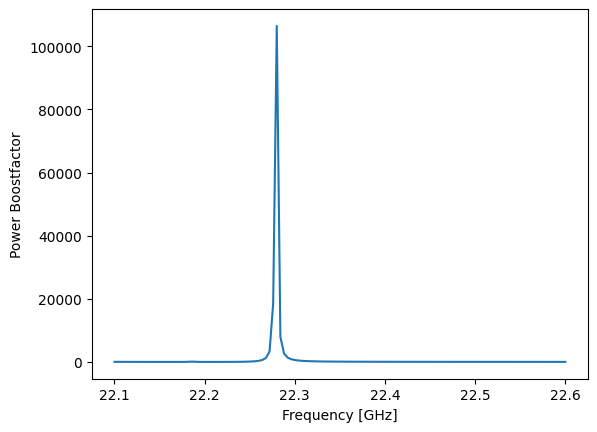

PyObject Text(24.0, 0.5, 'Power Boostfactor')

In [11]:
#Only plot fundamental mode
plot(frequencies_plot.*1e-9,abs2.(Eout_init)[1,Lmax+1,:])
xlabel("Frequency [GHz]")
ylabel("Power Boostfactor")

# Propagation Matrix Interpolation

In [12]:
#Calculate interpolation object for frequencies we want to optimize
#To avoid calculating the costly propagation matrix for each possible distance, we calculate it only at
#some points and interpolate the others. The spacing grid is relative distance changes from the provided sbdry struct.
#The grid steps shouldn't be larger than 50 um. Choose a sensible range from to safe computation (e.g. a small range if you
# are already close to the optimum, larger if far away) 
spacing_grid = (-2500:50:2500)*1e-6;

prop_matrix_grid_sub = calc_propagation_matrices_grid(sbdry_init,coords,modes,spacing_grid,frequencies_optim,diskR=diskR);
#This is the interpolation object that is being called when interpolating
itp_sub = construct_prop_matrix_interpolation(prop_matrix_grid_sub, spacing_grid);

# Optimization

In [13]:
#We define a single argument cost function for the optimizer
#m_reflect defines the combination of modes we want to optimize. For now we are only interested in the fundamental mode
function cost_fun(x)
    return calc_boostfactor_cost(x,itp_sub,frequencies_optim,sbdry_init,coords,modes,m_reflect,diskR=diskR)
end;

In [14]:
#With NelderMead. Slow but robust
options_nm = Optim.Options(g_tol = 1e-2,iterations=100000)
#Add some random variation to start spacing. Convergence very much depend on a good start point.
x_0 = 2 .* (rand(n_disk).-0.5) .* 100e-6
result_nm = optimize(cost_fun,x_0,NelderMead(),options_nm)

 * Status: success

 * Candidate solution
    Minimizer: [-2.93e-04, 2.21e-04, -1.23e-04,  ...]
    Minimum:   -1.034529e+04

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [-2.15e-05, 1.00e-04, -7.95e-05,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-02

 * Work counters
    Seconds run:   148  (vs limit Inf)
    Iterations:    11877
    f(x) calls:    17007


In [32]:
#Quasi-Newton (gradient-based). Fast but likes to get stuck in local minima. 
algorithm = BFGS()
options_optim = Optim.Options(f_tol = 1e-6)
#Add some random variation to start spacing. Convergence very much depend on a good start point.
x_0 = 2 .* (rand(n_disk).-0.5) .* 100e-6
od = OnceDifferentiable(cost_fun,x_0; autodiff=:forward)
result_qn = optimize(od,x_0,algorithm,options_optim)

 * Status: success

 * Candidate solution
    Minimizer: [8.36e-04, 2.21e-04, 3.70e-04,  ...]
    Minimum:   -7.013022e+03

 * Found with
    Algorithm:     BFGS
    Initial Point: [3.98e-05, 9.28e-05, -2.06e-05,  ...]

 * Convergence measures
    |x - x'|               = 2.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.61e-06 ≰ 1.0e-06
    |f(x) - f(x')|/|f(x')| = 5.15e-10 ≰ 0.0e+00
    |g(x)|                 = 1.37e+08 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    98
    f(x) calls:    1534
    ∇f(x) calls:   1534


In [33]:
#Plot results
#Create optimized setup
sbdry_optim = copy_setup_boundaries(sbdry_init,coords)
sbdry_optim.distance[2:2:end-2] .+= Optim.minimizer(result_qn)


#Calculate prop matrix grid at a dist shift of zero of optimized setup
prop_matrix_grid_plot = calc_propagation_matrices_grid(sbdry_optim,coords,modes,0,frequencies_plot,diskR=diskR);
prop_matrix_plot = [prop_matrix_grid_plot[r,f,1,1,1,:,:] for r=1:n_region, f=1:length(frequencies_plot)]
Eout_optim = calc_boostfactor_modes(sbdry_optim,coords,modes,frequencies_plot, prop_matrix_plot, diskR=diskR);


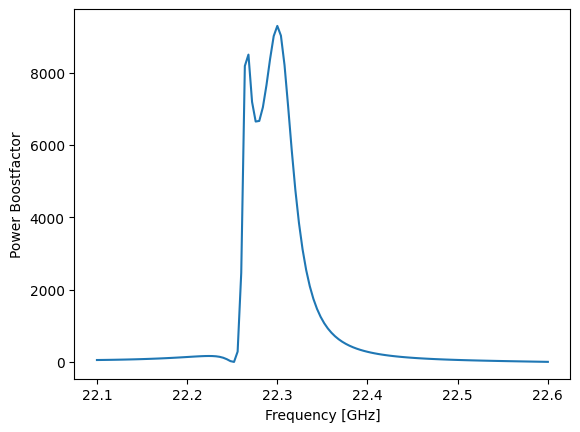

PyObject Text(24.0, 0.5, 'Power Boostfactor')

In [34]:
plot(frequencies_plot.*1e-9,abs2.(Eout_optim)[1,Lmax+1,:])
xlabel("Frequency [GHz]")
ylabel("Power Boostfactor")